<a href="https://www.kaggle.com/code/syerramilli/ps3e25-tabular-resnet-optuna?scriptVersionId=151171706" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

The goal of this regression task to predict the Mohs hardness scale of minerals based on their compositional feature descriptors. The Mohs hardness scale is a qualitative ordinal scale that characterizes the scratch resistance of various minerals through the ability of a harder material to scratch a softer material. It is extensively used in geology and material science. In this notebook, we will train and tune a [tabular resnet](https://proceedings.neurips.cc/paper/2021/hash/9d86d83f925f2149e9edb0ac3b49229c-Abstract.html) regression model to predict Mohs hardness. The resnet will be implemented using keras, and the hyperparameter tuning will be performed through Optuna.


TODO: More rigorus EDA and feature engineering


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
import keras
import keras.backend as K
from tensorflow_addons.optimizers import AdamW
from sklearn.preprocessing import QuantileTransformer

from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold, train_test_split

import optuna
from pathlib import Path

import shap
import joblib

from typing import Optional, Dict, Tuple

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi': 150})

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
data_path = Path('/kaggle/input/playground-series-s3e25')

train = pd.read_csv(data_path / 'train.csv', index_col=['id'])
test = pd.read_csv(data_path / 'test.csv', index_col=['id'])

train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [3]:
print(f'Shape of training data: {train.shape}')
print(f'Shape of test data: {test.shape}')

Shape of training data: (10407, 12)
Shape of test data: (6939, 11)


## Basic EDA

All the columns are numerical and there are no missing values

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


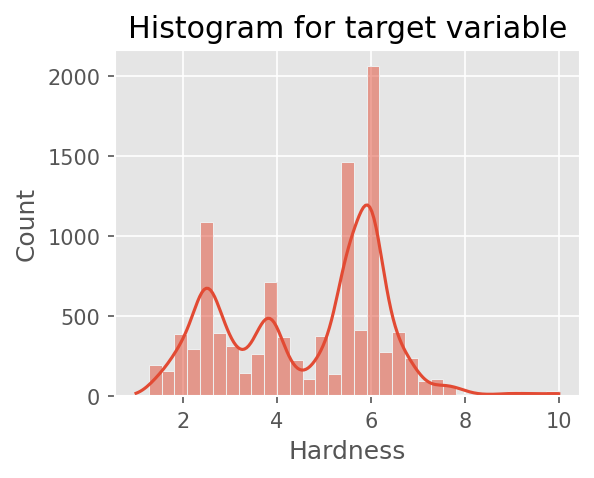

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
_ = sns.histplot(train, x='Hardness', kde=True, ax=ax)
_ = ax.set_title('Histogram for target variable')

Here are the histogram plots of the 11 features. Clearly, there are large outlies in many of the features. For now, we will not modify the outliers.

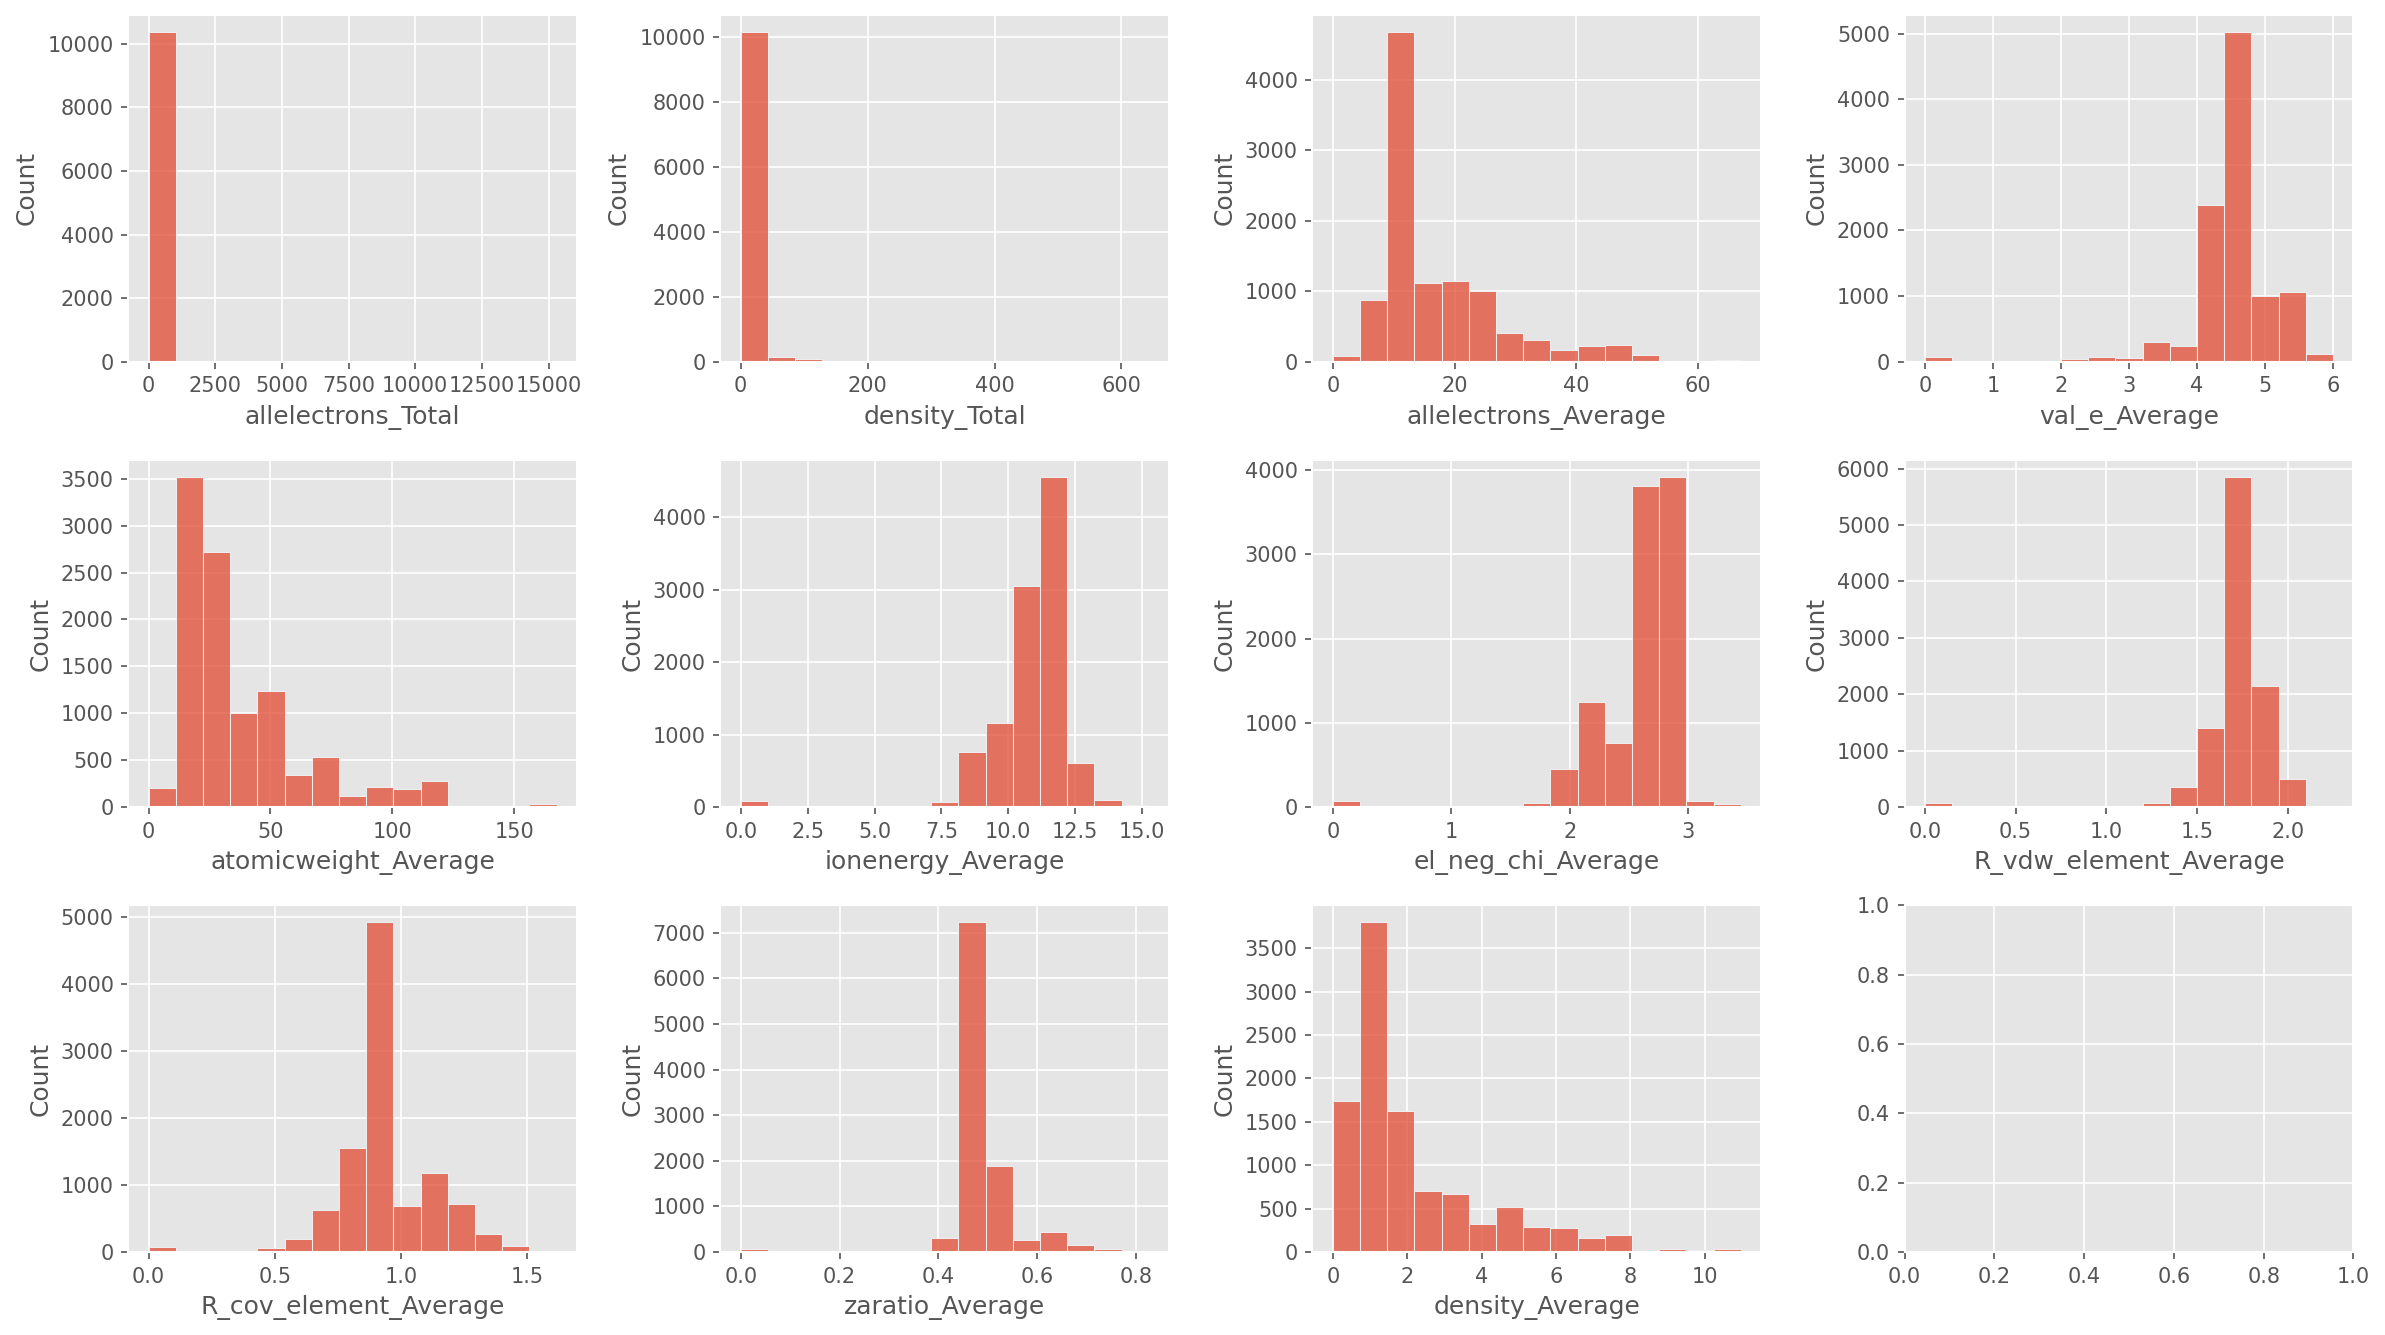

In [6]:
n_rows = 3
n_cols = 4

numerical_columns = train.drop('Hardness', axis=1).columns.tolist()
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols * i + j
        if col_idx == len(numerical_columns):
            break
        
        _ = sns.histplot(data=train, x=numerical_columns[col_idx], ax=axs[i, j], bins=15)

fig.tight_layout()

In [7]:
# prepare the dataframes
qt = QuantileTransformer()

X = qt.fit_transform(train.drop('Hardness', axis=1))
y = train['Hardness'].values

## Tabular Resnet architecture


From the [paper](https://proceedings.neurips.cc/paper_files/paper/2021/file/9d86d83f925f2149e9edb0ac3b49229c-Paper.pdf), the architecture of the tabular resnet is

```
ResNet(x) = Prediction(ResNetBlock(...(ResNetBlock(Linear(x)))
ResNetBlock(x) = x +  Dropout(Linear(Dropout(ReLU(Linear(NormalizationLayer(x)))
Prediction(x) = Linear(ReLU(NormalizationLayer(x))
```

`NormalizationLayer` can be one of `BatchNorm` or `LayerNorm`

See the code in the cell below for an implementation of the `ResNetBlock` in Keras.

In [8]:
def make_normalization(normalization, input_dim):
    '''utility function to return the normalization layer'''
    if normalization == 'batchnorm':
        return keras.layers.BatchNormalization(input_shape=(input_dim,))
    elif normalization == 'layernorm':
        return keras.layers.LayerNormalization(input_shape=(input_dim,))

class ResNetBlock(keras.layers.Layer):
    def __init__(
        self, 
        input_dim, 
        normalization,
        hidden_factor=2, hidden_dropout=0.1, 
        residual_dropout=0.05
    ):
        super().__init__()
        # hidden size
        d_hidden = int(hidden_factor * input_dim)
        
        self.ff = keras.models.Sequential([
            make_normalization(normalization, input_dim),
            keras.layers.Dense(d_hidden, activation='relu'),
            keras.layers.Dropout(hidden_dropout),  # first dropout
            keras.layers.Dense(input_dim),
            keras.layers.Dropout(residual_dropout)
        ])
        
    def call(self, x):
        return x + self.ff(x)

The function `construct_resnet_model` returns a compliled model, while the function `build_and_fit` returns the model trained on the data.

In [9]:
def tf_median_absolute_error(y_true, y_pred):
    median_error = tfp.stats.percentile(tf.abs(y_pred - y_true), 50.0)
    return median_error

def construct_resnet_model(params:Dict, input_dim:int) -> keras.Model:
    """
    Build a MLP tabular resnet regression model with L1 loss
    
    Arguments
    ---------
    params: dict
        Dictionary containing the hyperparameters of the model including learning rates
        and weight decay regularization
        
    input_dim: int
        Number of features
        
    Returns
    ---------
    model: keras.Model
        A compiled keras model
    """
    
    n_hidden = params.get('n_hidden', 2)
    layer_size = params.get('layer_size', 64)
    normalization = params.get('normalization', 'layernorm')
    hidden_factor = params.get('hidden_factor', 2.)
    hidden_dropout = params.get('hidden_dropout', 0.1)
    residual_dropout = params.get('residual_dropout', 0.05)
    
    model = keras.models.Sequential([
        keras.Input(shape=(input_dim, )),
        keras.layers.Dense(layer_size)
    ])
    
    for _ in range(n_hidden):
        model.add(ResNetBlock(layer_size, normalization, hidden_factor, hidden_dropout, residual_dropout))
    
    # output layer
    model.add(keras.Sequential([
        make_normalization(normalization, layer_size),
        keras.layers.ReLU(),
        keras.layers.Dense(1)
    ]))

    model.compile(
        optimizer=AdamW(
            learning_rate=params.get('learning_rate', 5e-2),
            weight_decay=params.get('weight_decay', 1e-6)
        ),
        loss='mean_absolute_error',
        metrics=[tf_median_absolute_error]
    )

    return model


def build_and_fit(
    X:np.ndarray,y:np.ndarray,
    params:Dict={},
    verbose:bool=False,
    resample_seed:Optional[int]=None
) -> keras.Model:
    
    #further divide into train and validation splits for early stopping
    X_train,X_val,y_train,y_val = train_test_split(
        X,y,test_size=0.1,random_state=resample_seed
    )
    
    EPOCHS = 100
    BATCH_SIZE = params.get('batch_size', 256)
    
    # callbacks - reduce lr on plateau and early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_tf_median_absolute_error',
        mode='min',
        verbose=verbose,
        patience=15,
        restore_best_weights=True
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_tf_median_absolute_error',
        mode='min',
        verbose=verbose,
        patience=5,
        factor=0.5,
        min_lr = 1e-5
    )
        
    # create model
    model = construct_resnet_model(params, X_train.shape[-1])

    # train model
    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping,reduce_lr],
        validation_data=(X_val, y_val),
        verbose=verbose,
    )

    return model

## Tuning hyperparameters via Bayesian optimization

We will now optimize the hyperparameters of the resnet model using optuna to minimize the 5-fold CV median absolute error. 

In [10]:
import warnings
def fit_and_test_fold(config:Dict, X:pd.DataFrame, y:np.ndarray, train_index:np.ndarray, test_index:np.ndarray) -> float:
    K.clear_session()
    X_train = X[train_index,:];X_test = X[test_index,:]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = build_and_fit(X_train, y_train, config)
    
    # generate predictions on test data
    test_pred = model.predict(X_test, verbose=False).ravel()
    
    return median_absolute_error(y_test, test_pred)


def optuna_objective(trial:optuna.Trial) -> float:
    config = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True),
        'n_hidden':trial.suggest_int('n_hidden', 1, 4),
        'layer_size': trial.suggest_int('layer_size', 8, 256, log=True),
        'normalization': trial.suggest_categorical('normalization', choices=['batchnorm', 'layernorm']),
        'hidden_factor': trial.suggest_float('hidden_factor', 1, 4),
        'hidden_dropout': trial.suggest_float('hidden_dropout', 0, 0.5),
        'residual_dropout': trial.suggest_float('residual_dropout', 0, 0.5),
    }
    
    n_splits = 5
    cv = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    cv_mae = [None] * n_splits
    for i, (train_index, test_index) in enumerate(cv.split(X,y)):
        cv_mae[i] = fit_and_test_fold(config, X, y, train_index, test_index)
        
    # saving the individual fold holdout metrics 
    # uncomment this line if you don't want this
    trial.set_user_attr('split_mae', cv_mae)
        
    return np.mean(cv_mae)

In [11]:
sampler = optuna.samplers.TPESampler(
    n_startup_trials=10, seed=123
)

study = optuna.create_study(
    directions=['minimize'], sampler=sampler,study_name='resnet'
)

# run optuna for a maxmimum of 100 trials and 2hr wall clock time
study.optimize(optuna_objective, n_trials=100, timeout=7200) 

# save the runs
_ = joblib.dump(study, 'resnet_hyperopt_hardness.pkl')


[I 2023-11-17 19:08:11,694] A new study created in memory with name: resnet
[I 2023-11-17 19:09:26,554] Trial 0 finished with value: 0.6143194890022278 and parameters: {'learning_rate': 0.02471373418487883, 'weight_decay': 1.3949458198611223e-05, 'n_hidden': 1, 'layer_size': 53, 'normalization': 'batchnorm', 'hidden_factor': 3.9422925951538463, 'hidden_dropout': 0.34241486929243165, 'residual_dropout': 0.24046595074218047}. Best is trial 0 with value: 0.6143194890022278.
[I 2023-11-17 19:11:25,596] Trial 1 finished with value: 0.5450097799301148 and parameters: {'learning_rate': 0.006084642077147054, 'weight_decay': 2.358913764815061e-05, 'n_hidden': 3, 'layer_size': 35, 'normalization': 'layernorm', 'hidden_factor': 3.213986217196107, 'hidden_dropout': 0.09124586522674999, 'residual_dropout': 0.08772587807374627}. Best is trial 1 with value: 0.5450097799301148.
[I 2023-11-17 19:15:04,227] Trial 2 finished with value: 0.5641480684280396 and parameters: {'learning_rate': 0.0115638579369

In [12]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV MdAE')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

In [13]:
results = study.trials_dataframe(attrs=('number','value', 'duration', 'params'))
results = results.rename(columns={'value':'MdAE'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='MdAE',ascending=True)
results.to_csv('cv_mdae_history.csv',index=False)
# print the top 10 results
results.head(10)

,number,MdAE,duration,params_hidden_dropout,params_hidden_factor,params_layer_size,params_learning_rate,params_n_hidden,params_normalization,params_residual_dropout,params_weight_decay
30,30,0.508948,301.767635,0.239752,3.913448,69,0.003256,4,layernorm,0.009864,0.000472
35,35,0.514242,350.068596,0.224294,3.996406,137,0.006634,4,layernorm,0.013645,0.000188
32,32,0.518723,262.598512,0.239200,3.950150,74,0.003695,4,layernorm,0.006185,0.000526
31,31,0.521276,212.553634,0.236724,3.792904,71,0.003415,4,layernorm,0.018866,0.000485
37,37,0.531469,313.335530,0.233309,3.850679,136,0.003442,4,layernorm,0.033898,0.000182
34,34,0.534447,262.240857,0.204316,3.989373,116,0.006075,4,layernorm,0.006210,0.000304
33,33,0.535666,252.041057,0.191752,3.987763,104,0.003942,4,layernorm,0.021706,0.000466
39,39,0.537164,276.191792,0.211084,3.992838,90,0.009002,4,layernorm,0.028052,0.000115
41,41,0.538724,346.796921,0.240209,3.842844,141,0.003286,4,layernorm,0.034630,0.000191
26,26,0.539396,132.413286,0.160677,3.351676,48,0.002612,3,layernorm,0.057502,0.000584


## Final model - ensembling

Rather than training a single model, we will train an ensemble of models, where each model is trained using a different training-validation split (and possibly different initial guessess for the parameters of the network).

In [14]:
n_ensemble = 10
models = [None] * n_ensemble

for i in range(n_ensemble):
    print(f'********* Model {i+1} *********')
    with warnings.catch_warnings():
        # PossibleUserWarnings 
        warnings.simplefilter(action='ignore')
        models[i] = build_and_fit(X, y, study.best_params, verbose=False, resample_seed=i)
    
    print()

********* Model 1 *********

********* Model 2 *********

********* Model 3 *********

********* Model 4 *********

********* Model 5 *********

********* Model 6 *********

********* Model 7 *********

********* Model 8 *********

********* Model 9 *********

********* Model 10 *********



In [15]:
# Create ensemble model in Keras
model_input = keras.Input(shape=(X.shape[1],))
model_outputs = [model(model_input) for model in models]
ensemble_output = keras.layers.Average()(model_outputs)
ensemble_model = keras.Model(inputs=model_input, outputs=ensemble_output)

print(ensemble_model.summary())

ensemble_model.save('ensemble_model.keras')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 11)]                 0         []                            
                                                                                                  
 sequential_6 (Sequential)   (None, 1)                    151984    ['input_12[0][0]']            
                                                                                                  
 sequential_12 (Sequential)  (None, 1)                    151984    ['input_12[0][0]']            
                                                                                                  
 sequential_18 (Sequential)  (None, 1)                    151984    ['input_12[0][0]']            
                                                                                              

## Test predictions

In [16]:
X_test = qt.transform(test)
y_test_pred = ensemble_model.predict(X_test).ravel()

submission = pd.DataFrame({
    'id':test.index.values,
    'Hardness': y_test_pred
})
submission.to_csv('submission.csv',index=False)


217/217 [==============================] - 6s 13ms/step
